![lop](../../images/logo_diive1_128px.png)

<span style='font-size:40px; display:block;'>
<b>
    Quick random forest gap-filling
</b>
</span>

---
**Notebook version**: `1` (8 Sep 2023)  
Example notebook for the class `pkgs.gapfilling.randomforest_ts.QuickFillRFTS` using the time series processing library `diive`.  
**Author**: Lukas Hörtnagl (holukas@ethz.ch)  


</br>

---

# **Background**

- A simple random forest model is built and used for quick gap-filling
- Although this typically works well, this class is not meant for "final" gap-filling
- To speed up processing, the number of estimators is by default `20`

</br>

---

# **Setup**

## User settings
`TARGET_COL` ... name of the time series that is gap-filled  
`subsetcols` ... list of columns included in the random forest model, target must also be listed here

All columns that are not the target will be used as features/predictors during model building.

In [1]:
TARGET_COL = 'NEE_CUT_REF_orig'
subsetcols = [TARGET_COL, 'Tair_f', 'VPD_f', 'Rg_f']

## Imports
- This notebook uses `diive` ([source code](https://gitlab.ethz.ch/diive/diive)) to check eddy covariance fluxes for quality

In [2]:
import numpy as np
import importlib.metadata
import matplotlib.pyplot as plt
from datetime import datetime
from diive.configs.exampledata import load_exampledata_pickle
from diive.core.plotting.timeseries import TimeSeries  # For simple (interactive) time series plotting
from diive.core.dfun.stats import sstats  # Time series stats
from diive.core.plotting.heatmap_datetime import HeatmapDateTime
from diive.pkgs.gapfilling.randomforest_ts import QuickFillRFTS
dt_string = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"This page was last modified on: {dt_string}")
version_diive = importlib.metadata.version("diive")
print(f"diive version: v{version_diive}")

Loading BokehJS ...

This page was last modified on: 2023-10-04 19:48:19
diive version: v0.63.0


### Show docstring for `QuickFillRFTS`

In [3]:
print(QuickFillRFTS.__name__)
print(QuickFillRFTS.__doc__)

QuickFillRFTS

    Quick gap-filling using RandomForestTS with pre-defined parameters

    The purpose of this class is preliminary gap-filling e.g. for quick tests
    how gap-filled data could look like. It is not meant to be used for
    final gap-filling.
    


</br>

---

# **Load data**

## Load example data from pickle file

In [4]:
df = load_exampledata_pickle()

Loaded pickle F:\Sync\luhk_work\20 - CODING\21 - DIIVE\diive\diive\configs\exampledata\exampledata_CH-DAV_FP2022.5_2022_ID20230206154316_30MIN.diive.csv.pickle (0.127 seconds).


## Make subset

In [5]:
lowquality = df["QCF_NEE"] > 0  # This example uses NEE flux data, only records where the quality flag QCF is 0 (highest quality) are retained
df.loc[lowquality, TARGET_COL] = np.nan  # Set fluxes of lower quality to missing
df = df[subsetcols].copy()  # Keep subset columns only

In [6]:
df.describe()

,NEE_CUT_REF_orig,Tair_f,VPD_f,Rg_f
count,4438.000000,17520.000000,17520.000000,17520.000000
mean,-3.677626,5.609281,3.527302,164.732211
std,5.520598,7.753765,4.073855,263.544729
min,-22.407090,-15.073333,0.000000,0.000000
25%,-7.437390,-0.274167,0.616878,0.000000
50%,-3.916538,5.586667,2.237138,4.126754
75%,0.616780,11.116667,4.779282,248.026818
max,18.455330,26.586667,27.282137,1084.134983


In [7]:
sstats(df[TARGET_COL])

,NEE_CUT_REF_orig
STARTDATE,2022-01-01 00:15
ENDDATE,2022-12-31 23:45
PERIOD,364 days 23:30:00
NOV,4438
MISSING,13082
MISSING_PERC,74.66895
MEAN,-3.677626
SD,5.520598
VAR,30.477001
SD/MEAN,-1.501131


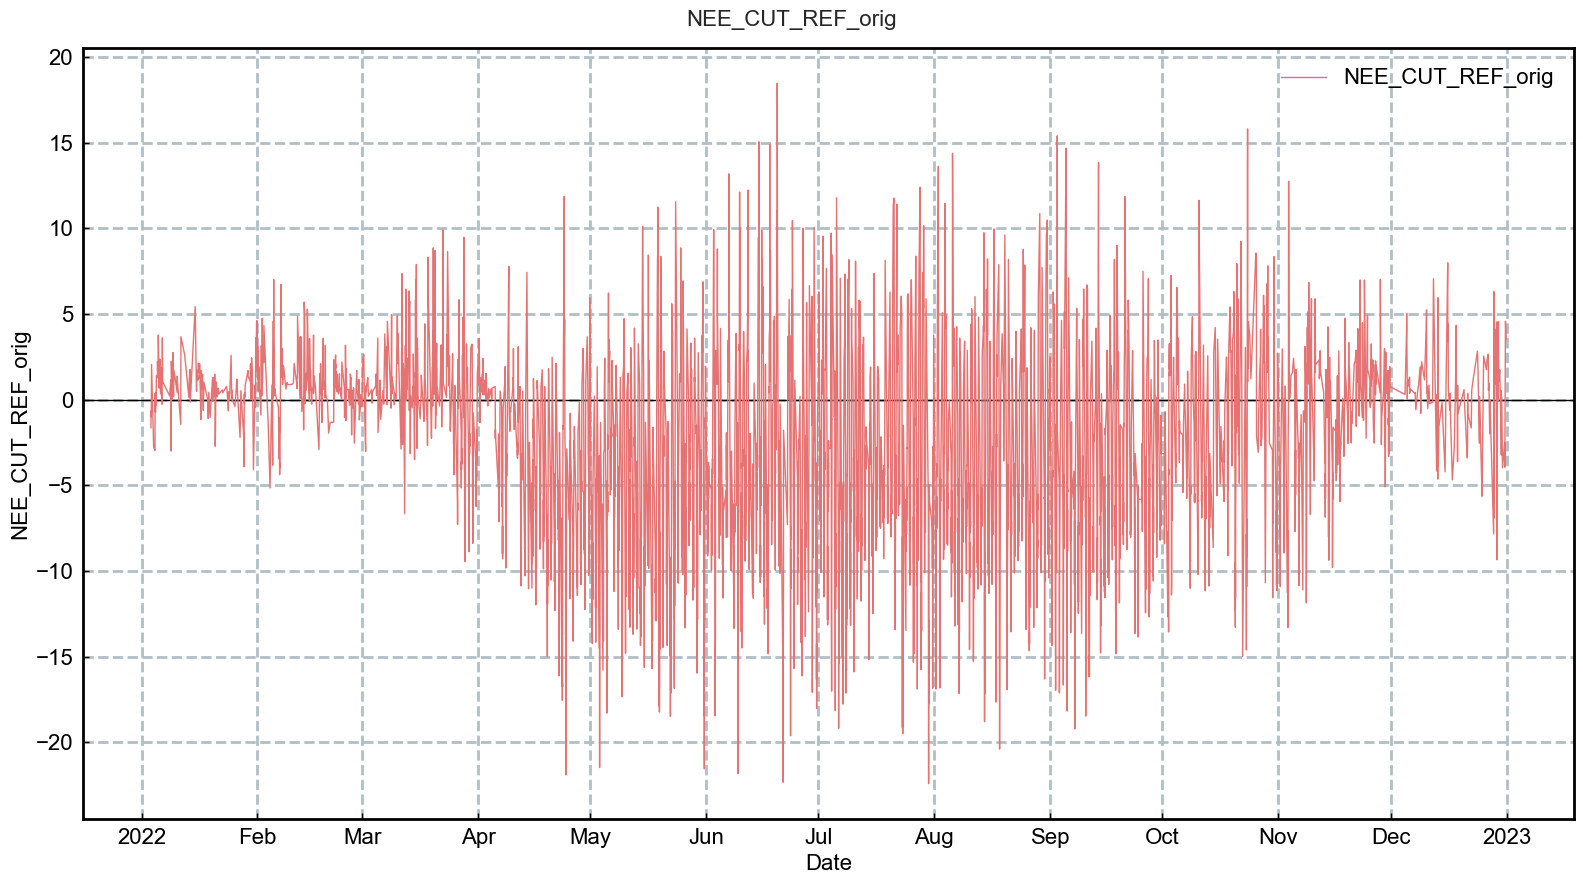

In [8]:
TimeSeries(series=df[TARGET_COL]).plot()

In [9]:
TimeSeries(series=df[TARGET_COL]).plot_interactive()

</br>

</br>

---

# **Gap-filling**

</br>


Creating lagged variants ...
Created lagged variants for: ['Tair_f', 'VPD_f', 'Rg_f'] (lags between -1 and -1 with stepsize 1)
No lagged variants for: ['NEE_CUT_REF_orig']

Adding timestamp as data columns ...
Added timestamp as columns: ['.YEAR', '.SEASON', '.MONTH', '.WEEK', '.DOY', '.HOUR', '.YEARMONTH', '.YEARDOY', '.YEARWEEK'] 

Adding continuous record number ...
Added new column .RECORDNUMBER with record numbers from 1 to 17520.

Sanitizing timestamp ...
Validating timestamp naming of timestamp column TIMESTAMP_MIDDLE ... Timestamp name OK.
Converting timestamp TIMESTAMP_MIDDLE to datetime ... OK
Sorting timestamp TIMESTAMP_MIDDLE ascending ... Removing data records with duplicate indexes ... OK (no duplicates found in timestamp index)
Creating continuous <30 * Minutes> timestamp index for timestamp TIMESTAMP_MIDDLE between 2022-01-01 00:15:00 and 2022-12-31 23:45:00 ... Building random forest model based on data between 2022-01-01 00:15:00 and 2022-12-31 23:45:00 ...


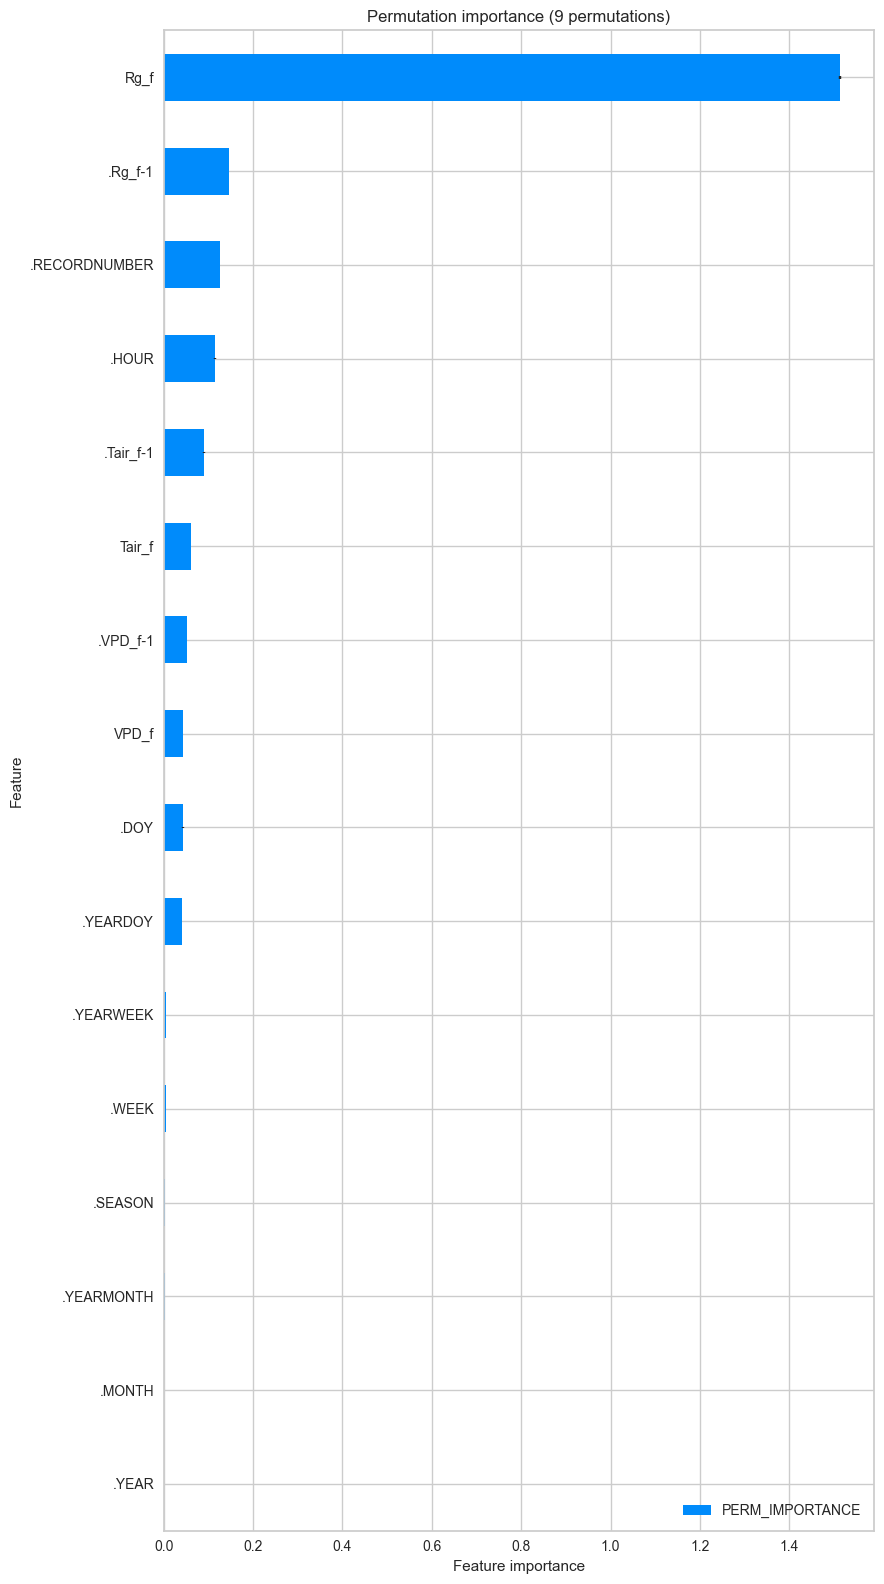

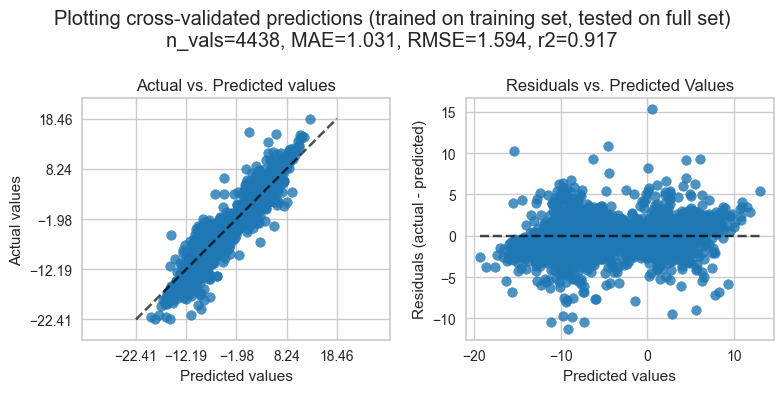


Adding timestamp as data columns ...
Added timestamp as columns: ['.YEAR', '.SEASON', '.MONTH', '.WEEK', '.DOY', '.HOUR', '.YEARMONTH', '.YEARDOY', '.YEARWEEK'] (ONLY FALLBACK)


In [10]:
qf = QuickFillRFTS(df=df, target_col=TARGET_COL)
qf.fill()
gapfilled = qf.get_gapfilled()

In [11]:
qf.report()


GAP-FILLING RESULTS

Model scores and feature importances were calculated from high-quality predicted targets (13081 values, NEE_CUT_REF_orig_gfRF where flag=1) in comparison to observed targets (4438 values, NEE_CUT_REF_orig).

## TARGET
- first timestamp:  2022-01-01 00:15:00
- last timestamp:  2022-12-31 23:45:00
- potential number of values: 17520 values)
- target column (observed):  NEE_CUT_REF_orig
- missing records (observed):  13082 (cross-check from flag: 13082)
- target column (gap-filled):  NEE_CUT_REF_orig_gfRF  (17520 values)
- missing records (gap-filled):  0
- gap-filling flag: FLAG_NEE_CUT_REF_orig_gfRF_ISFILLED
  > flag 0 ... observed targets (4438 values)
  > flag 1 ... targets gap-filled with high-quality, all features available (13081 values)
  > flag 2 ... targets gap-filled with fallback (1 values)

## FEATURE IMPORTANCES
- names of features used in model:  ['Rg_f', '.Rg_f-1', '.RECORDNUMBER', '.HOUR', '.Tair_f-1', 'Tair_f', '.VPD_f-1', 'VPD_f', '.DOY', '.YEARDOY

</br>

## **Plot**

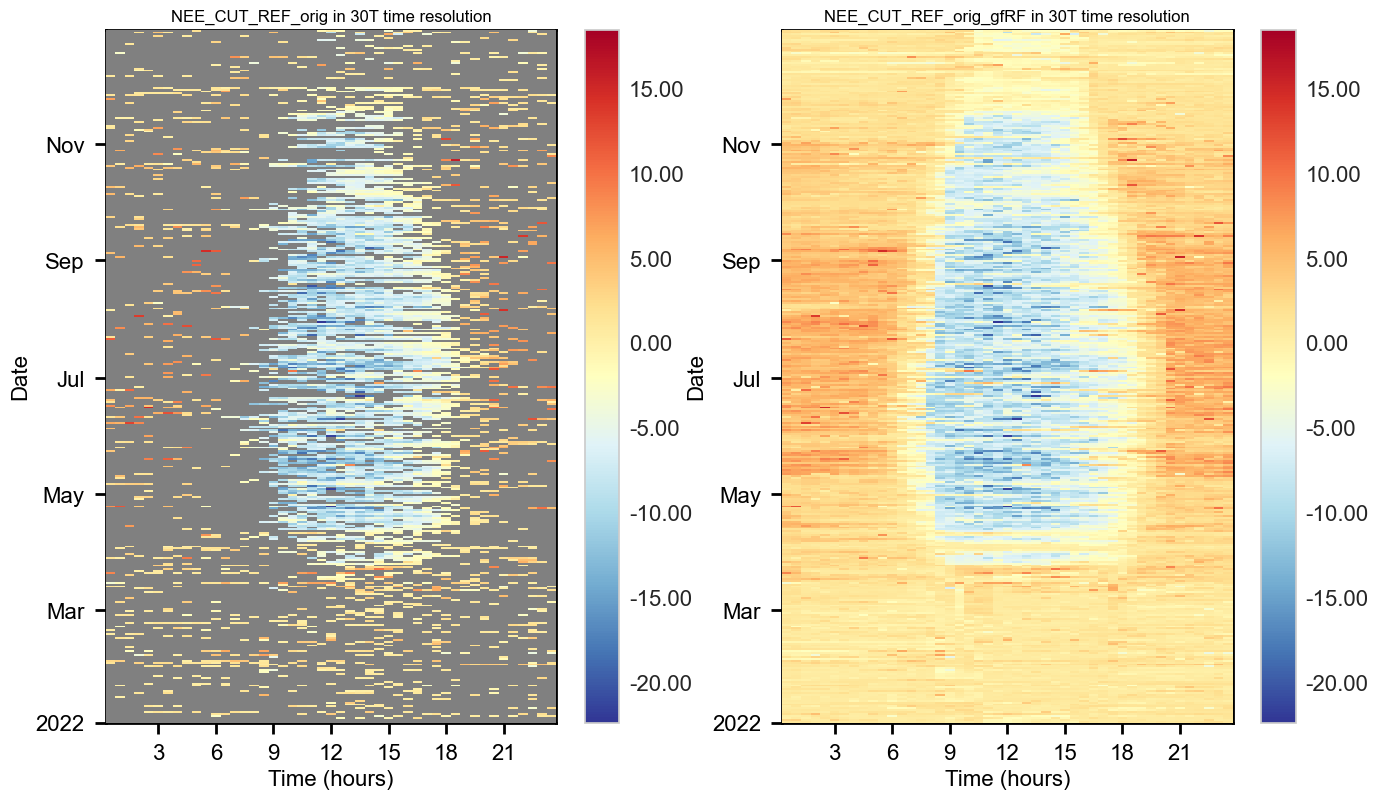

In [12]:
fig, axs = plt.subplots(ncols=2, figsize=(16, 9))
HeatmapDateTime(series=df[TARGET_COL], ax=axs[0]).plot()
HeatmapDateTime(series=gapfilled, ax=axs[1]).plot()

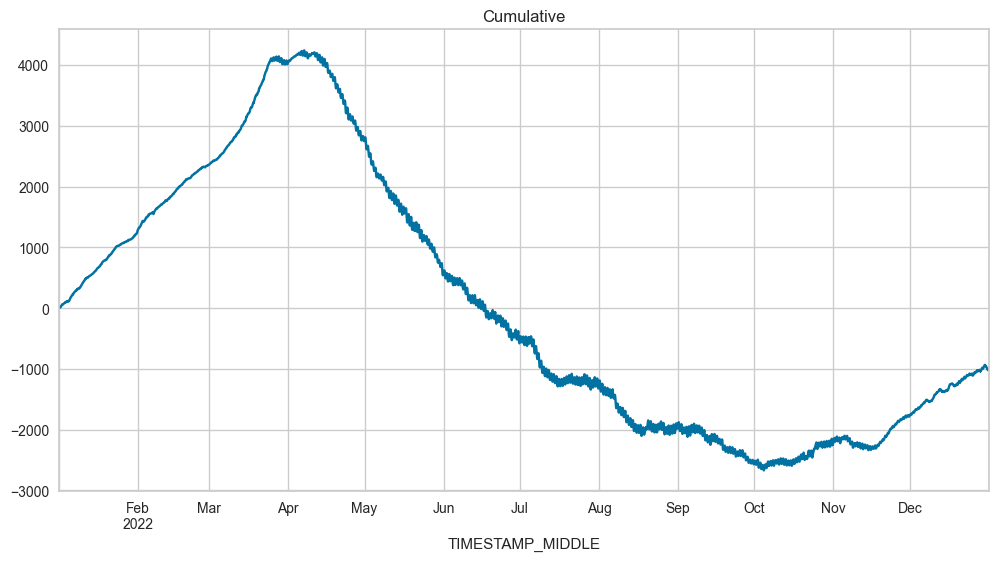

In [13]:
gapfilled.cumsum().plot(title=f"Cumulative", figsize=(12, 6));

# **End of notebook**
Congratulations, you reached the end of this notebook! Before you go let's store your finish time.

In [14]:
dt_string = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"Finished. {dt_string}")

Finished. 2023-10-04 19:48:48
